# Inhibitor Diffusion and Germination - Basic Setup

## Numerical experiments - Week 44/2024

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda, float32

## 1. General assumptions

Medium and conidium sizes:
- The diameter of a spore is assumed to be $5 \mu \textrm{m}$.
- The experiments are performed on a two-dimensional square lattice, in which a spore is approximated by a $5 \mu \textrm{m} \times 5 \mu \textrm{m}$ square in the middle of the lattice.
- This would correspond to a $5 \mu \textrm{m}$ high medium layer (same height as the spore), clamped between two non-permeable sheets.
- The cubic spore therefore has a volume of $5 \mu \textrm{m} \times 5 \mu \textrm{m} \times 5 \mu \textrm{m}=1.25\times 10^{-7}\textrm{mm}^3$

Concentrations:
- The medium is assumed to be water.
- A spore is assumed to contain a non-replenishable quantity of inhibitor, having a similar molar volume at room temperature as glucose ($V_m\approx 110 \textrm{cm}^3/\textrm{mol}=110\times10^3 \textrm{mm}^3/\textrm{mol}$)[2].
- The diffusion coefficient of glucose in water at temperature $T = 293.15 K$ is $D_g=600 µm^2/s=0.0006 \textrm{mm}^2/s$[1].
- The distribution of this quantity is measured by its concentration in discrete time and space: $c(x,y,t)=\frac{N}{V}$ in $\textrm{mol}/\textrm{mm}^3$, where $N$ is the quantity of molecules and $V$ is the volume.
- If the inhibitor is assumed to be distributed homogeneously within the conidium and be the only substance filling its volume, the maximum possible concentration of $N=\frac{V}{V_m}$ moles of inhibitor within the volume $V$ can be expressed as
$$
c_{\textrm{max}}=\frac{N}{V}=\frac{V}{VV_m}=\frac{1}{V_m}.
$$
- Hence, a spore volume can contain, at maximum, the inverse of the molar volume, which is approximately $0.9\times 10^{-5}\textrm{mol}/\textrm{mm}^3$.

Further assumptions:
- The permeability of the spore membrane is not considered, i.e. it is assumed that the inhibitor is released into the medium without any additional resistance.
- The transition from dormancy to germination is considered to be an instananeous switch once the concentration of inhibitor in the spore has decreased below a given threshold.

## 2. Mathematical framework

The presented model is used to simulate the diffusion of inhibitor concentrations $c$ over a square two-dimensional lattice, implementing the time-based diffusion equation with a diffusion coefficient $D$:

$$
\frac{\partial c}{\partial t}=D\nabla^2c.\tag{2}
$$

### 2.1. Discretisation

It is assumed that the lattice is discretised with equal subdivisions in every dimension: $\delta{x}=\delta{y}=1/N$, where $N$ is the number of lattice subdivisions along one dimension.

Time is discretised in steps of size $\delta t$. The left-hand side of the equation can be approximated by a forward finite difference to obtain

$$
\frac{\partial c}{\partial t}=\frac{c_{i,j}^{n+1}-c_{i,j}^{n}}{\delta{t}},
$$

where $i$ and $j$ are the discrete node indices in the $x$ and $y$ dimension, respectively, and $n$ is the time step index.

The Laplacian of the concentration can be expressed as

$$
\nabla^2c = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}
$$

and each of the partial derivatives can be approximated as second-order forward finite differences:

$$
\frac{\partial^2 c}{\partial x^2} = \frac{c_{i+1,j}^{n}+c_{i-1,j}^{n}-2c_{i,j}^{n}}{\delta{x^2}}
$$

$$
\frac{\partial^2 c}{\partial y^2} = \frac{c_{i,j+1}^{n}+c_{i,j-1}^{n}-2c_{i,j}^{n}}{\delta{x^2}}
$$

Combining the above expression yields the update scheme:

$$
c_{i,j}^{n+1} = \frac{D\delta{t}}{\delta{x^2}}(c_{i+1,j}^{n}+c_{i-1,j}^{n}+c_{i,j+1}^{n}+c_{i,j-1}^{n}-4c_{i,j}^{n}) + c_{i,j}^{n}
$$

The boundary is periodic in each dimension.

In [2]:
def diffusion_time_dependent(c_init, t_max, D=1.0, dt=0.001, dx=0.005, n_save_frames=100, c_thresh=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        c_thresh (float) - a threshold value for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 2, 'input array must be 2-dimensional'
    assert c_init.shape[0] == c_init.shape[1], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    Ddtdx2 = D * dt / (dx ** 2)

    if  Ddtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt)) + 1
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} mm.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0
    time_thresh = None

    # Initialise current state
    c_curr = np.array(c_init)

    for t in range(n_frames):

        # print(f"Frame {t} of {n_frames}", end="\r")

        # Compute next state
        c_curr_bottom = np.roll(c_curr, -1, axis=0)
        c_curr_top = np.roll(c_curr, 1, axis=0)
        c_curr_left = np.roll(c_curr, -1, axis=1)
        c_curr_right = np.roll(c_curr, 1, axis=1)

        c_next = Ddtdx2 * (c_curr_bottom + c_curr_top + c_curr_left + c_curr_right - 4 * c_curr) + c_curr
        
        # Update current array
        c_curr = np.array(c_next)

        # Save time if threshold is reached
        if c_thresh is not None and time_thresh is None:
            if np.max(c_curr) < c_thresh:
                time_thresh = t * dt

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = np.array(c_curr)
            times[save_ct] = t * dt
            save_ct += 1

    return c_evolution, times, time_thresh

**GPU version:**

In [ ]:
def invoke_smart_kernel(size, threads_per_block=(16, 16)):
    """
    Invoke a kernel with the appropriate number of blocks and threads per block.
    """
    blocks_per_grid = [(size + (tpb - 1)) // tpb for tpb in threads_per_block]
    return tuple(blocks_per_grid), tuple(threads_per_block)


@cuda.jit()
def update_GPU(c_old, c_new, Ddtdx2):
    """
    Update the concentration of a lattice point based on the time-dependent diffusion equation with a periodic boundary.
    inputs:
        c_old (numpy.ndarray) - the current state of the lattice;
        c_new (numpy.ndarray) - the next state of the lattice;
        Ddtdx2 (float) - the update factor.
    """
    i, j = cuda.grid(2)

    if i >= c_old.shape[0] or j >= c_old.shape[1]:
        return

    center = c_old[i, j]
    bottom = c_old[(i + 1) % c_old.shape[0], j]
    top = c_old[(i - 1) % c_old.shape[0], j]
    left = c_old[i, (j - 1) % c_old.shape[1]]
    right = c_old[i, (j + 1) % c_old.shape[1]]

    c_new[i, j] = Ddtdx2 * (bottom + top + left + right - 4 * center) + center


@cuda.reduce
def max_reduce(a, b):
    """
    Find the maximum of two values.
    """
    if a > b:
        return a
    else:
        return b


def diffusion_time_dependent_GPU(c_init, t_max, D=1.0, dt=0.001, dx=0.005, n_save_frames=100, c_thresh=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        c_thresh (float) - a threshold value for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 2, 'input array must be 2-dimensional'
    assert c_init.shape[0] == c_init.shape[1], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    Ddtdx2 = D * dt / (dx ** 2)

    if  Ddtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt)) + 1
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} mm.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0
    time_thresh = None

    # Initialise lattice states
    c_A_gpu = cuda.to_device(c_init)
    c_B_gpu = cuda.device_array_like(c_init)
    c_grids = [c_A_gpu, c_B_gpu]

    kernel_blocks, kernel_threads = invoke_smart_kernel(N)

    for t in range(n_frames):

        # print(f"Frame {t} of {n_frames}", end="\r")

        # c_curr = c_grids[t%2]
        # c_next = c_grids[(t+1)%2]
        update_GPU[kernel_blocks, kernel_threads](c_grids[t%2], c_grids[(t+1)%2], Ddtdx2)

        # Synchronize the GPU to ensure the kernel has finished
        cuda.synchronize()

        # Save time if threshold is reached
        if c_thresh is not None and time_thresh is None:
            if max_reduce(c_grids[(t+1)%2].ravel()) < c_thresh:
                time_thresh = t * dt

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = c_grids[(t+1)%2].copy_to_host()
            times[save_ct] = t * dt
            save_ct += 1

    return c_evolution, times, time_thresh

### 2.2. Analytical solution

The setup corresponds to a scaled two-dimensional Dirac-delta pulse of concentration at $t=0$ at the spore site $(x_0,y_0)$, followed by a gradual equilibration. This simple diffusion problem can also be solved analytically for the concentration on an arbitrary site $c(x,y)$ on a 2D lattice through the formula[3]

$$
c(x,y,t)=\frac{N^{2/3}}{4\pi Dt}\exp{\left(-\frac{(x-x_0)^2+(y-y_0)^2}{4Dt}\right)}.
$$

Here $N$ is the number of molecules and can be expressed as $N=Vc(x_0,y_0,t=0)$. For the concentration at the spore site, $c(x_0, y_0)$, this expression is simplified to

$$
c(x_0,y_0,t)=\frac{(Vc(x_0,y_0,t=0))^{2/3}}{4\pi Dt}.
$$

This provides a method to verify the correctness of the numerical solution.

In [3]:
def diffusion_time_dependent_analytical(c_init, D, time, vol):
    """
    Compute the analytical solution of the time-dependent diffusion equation.
    inputs:
        c_init (float) - the initial concentration;
        D (float) - the diffusion constant;
        time (float) - the time at which the concentration is to be computed;
        vol (float) - the volume of the initial concentration cell.
    """
    return np.power(vol * c_init, 2/3) / (4*np.pi*D*time)

## 3. Experimental setup

A spore occupies a single node at the centre of a $W\times H$ lattice. At this node, an initial inhibitor concentration $c_i=c_{\textrm{max}}$ is defined, everywhere else the lattice is initiated with $c_i=0$.

The lattice spacing and size are thus calibrated to correspond to a typical size of a conidium, i.e. $\delta x = 5 \mu m$ and $L=400\delta x = 2 \textrm{mm}$.

The iterations are computed with a time step $\delta t=0.1 \textrm{ms}=0.0001 \textrm{s}$.

In [25]:
# Initialise lattice with zero concentrations
W = 400
H = 400
c_lattice = np.zeros((W+1, H+1))

# Define spore index and set concentration
c_spore_init = 1#0.9e-5
spore_idx = (W // 2, H // 2)
c_lattice[spore_idx] = c_spore_init

# # Run simulation
c_thresh = 0.1 * c_spore_init
D = 0.0006
t_max = 100
c_evolution, times, time_thresh = diffusion_time_dependent(c_lattice, t_max=t_max, D=D, dt=0.01, n_save_frames=100, c_thresh=c_thresh)

# Check with analytical solution
spore_vol = 1.25e-7
print(f"Total concentration at final step: {np.sum(c_evolution[-1])}")
c_analytical = diffusion_time_dependent_analytical(c_spore_init, D, t_max, spore_vol)
print(f"Numerical solution at spore for t_max={t_max}: {c_evolution[-1, spore_idx[0], spore_idx[1]]}")
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical}")

Simulation running for 10001 steps on a lattice of size [2.005 2.005] mm.
Total concentration at final step: 1.0
Numerical solution at spore for t_max=100: 3.315238302550684e-05
Analytical solution at spore for t_max=100: 3.315727981081155e-05


**GPU implementation:**

In [31]:
# Initialise lattice with zero concentrations
W = 400
H = 400
c_lattice = np.zeros((W+1, H+1))

# Define spore index and set concentration
c_spore_init = 1#0.9e-5
spore_idx = (W // 2, H // 2)
c_lattice[spore_idx] = c_spore_init

# # Run simulation
c_thresh = 0.1 * c_spore_init
D = 0.0006
t_max = 100
c_evolution, times, time_thresh = diffusion_time_dependent_GPU(c_lattice, t_max=t_max, D=D, dt=0.01, n_save_frames=100, c_thresh=c_thresh)

# Check with analytical solution
spore_vol = 1.25e-7
print(f"Total concentration at final step: {np.sum(c_evolution[-1])}")
c_analytical = diffusion_time_dependent_analytical(c_spore_init, D, t_max, spore_vol)
print(f"Numerical solution at spore for t_max={t_max}: {c_evolution[-1, spore_idx[0], spore_idx[1]]}")
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical}")

Simulation running for 10001 steps on a lattice of size [2.005 2.005] mm.
Total concentration at final step: 0.9999721727991742
Numerical solution at spore for t_max=100: 3.3152375093164045e-05
Analytical solution at spore for t_max=100: 3.315727981081155e-05


## 4. Results

The plots below visualise the results from the simulation run. The first plot shows the inhibitor concentration at the spore over time, the second one provides a snapshop of the inhibitor distribution over the entire lattice.

In [ ]:
# Test analytical solution for 1 hour
c_spore_init = 10
D = 600
t_max = 3600
cell_wall_volume = 150 * 0.5
c_analytical = diffusion_time_dependent_analytical(c_spore_init, D, t_max, cell_wall_volume)
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical}")

Analytical solution at spore for t_max=3600: 3.0411923807372843e-06


Concentration dropped below 0.1 at time 0.0398


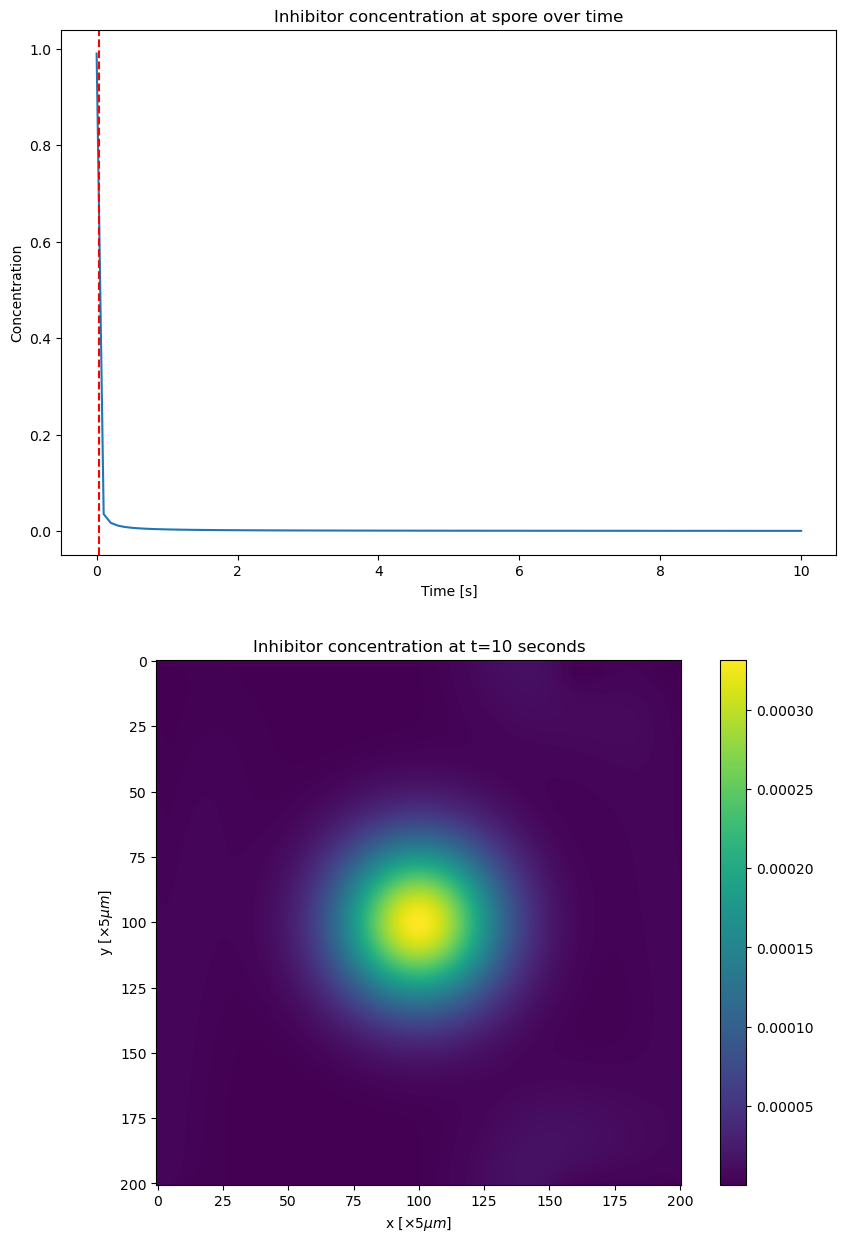

In [7]:
print(f"Concentration dropped below {c_thresh} at time {time_thresh}")

fig, axs = plt.subplots(2, 1, figsize=(10, 15))
axs[0].plot(times, c_evolution[:, spore_idx[0], spore_idx[1]])
axs[0].axvline(x=time_thresh, color='r', linestyle='--')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Concentration')
axs[0].set_title('Inhibitor concentration at spore over time')
img = axs[1].imshow(c_evolution[-1], cmap='viridis')
axs[1].set_xlabel(f'x [$\\times 5\\mu m$]')
axs[1].set_ylabel(f'y [$\\times 5\\mu m$]')
axs[1].set_title(f'Inhibitor concentration at t={t_max} seconds')
fig.colorbar(img, ax=axs[1])

It can also be observed that the time for reaching the percentual threshold does not change under different initial concentrations.

## 5. Discussion

Both the numerical and the analytical solution suggest that the inhibitor concentration drops very rapidly with time at the spore site. The inhibitor in the conidium diffuses below $10\%$ of its original concentration within the first 40 milliseconds. This is inconsistent with the observation that germination events occur at an hourly scale and indicates that the model may not correctly represent the mechanisms of inhibitor release.

Several extensions are possible at this point:
- incorporating slow-resease through gradually increasing cell membrane permeability;
- representing a single spore as a bounded region in space instead of a single lattice node.

## References

- [1] R. Hober, “Physical chemistry of cells and tissues,” 1945.
- [2] A. F. Fucaloro, Y. Pu, K. W. Cha, A. J. S. Williams, and K. M. Conrad, “Partial Molar Volumes and Refractions of Aqueous Solutions of Fructose, Glucose, Mannose, and Sucrose at 15.00, 20.00, and 25.00 °C,” Journal of Solution Chemistry, vol. 36, pp. 61–80, 2007.
- [3] P. C. Nelson, M. Radosavljevic, and S. Bromberg, “Biological Physics: Energy, Information, Life,” 2003.
